<a href="https://colab.research.google.com/github/imranmurtaza110/RL_Lunar_lander/blob/main/lunar_lander_updated_epsilon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium
!pip install swig
!apt-get install -y python-box2d
!pip install gymnasium[box2d]
!pip install pyvirtualdisplay
!apt-get update
!apt-get install -y xvfb
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg swig

In [5]:
from pyvirtualdisplay import Display
from IPython.display import display as ipy_display, HTML
from base64 import b64encode
display = Display(visible=0, size=(1400, 900))
display.start()

from gymnasium.wrappers import RecordVideo

In [6]:
import gymnasium as gym

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class DeepQLearning(nn.Module):
  def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

  def forward(self, x):
    return self.model(x)

In [11]:
class LossFunction:
  def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

  def step(self, loss):
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()


In [53]:
import numpy as np
import random

class Agent:
  def __init__(self, action_space, observation_space, model):
    self.action_space = action_space
    self.observation_space = observation_space
    self.epsilon = 0.5
    self.epsilon_decay = 0.001
    self.experience_buffer = []
    self.model = model
    self.min_epsilon = 0.01
    self.optimizer = LossFunction(self.model)


  def update_epsilon(self):
        if self.epsilon not in [0.01]:
          if self.epsilon > self.min_epsilon:
            self.epsilon -= self.epsilon_decay
          elif self.epsilon < 0:
            self.epsilon = self.min_epsilon

        return self.epsilon


  def select_action(self, state):
    if np.random.random() < self.epsilon:
        return np.random.randint(self.action_space)
    else:
        if not state[1]:
          state_tensor = torch.FloatTensor(state[0][0:8]).unsqueeze(0)
        else:
          state_tensor = torch.FloatTensor(state).unsqueeze(0)

        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()


  def experience_replay_buffer(self, state, action, reward, next_state, done):
      self.experience_buffer.append((state, action, reward, next_state, done))


  def play(self, batch_size, gamma):
        if len(self.experience_buffer) < batch_size:
            return

        batch = random.sample(self.experience_buffer, batch_size)

        states = []
        actions = []
        rewards = []
        next_states = []
        is_done = []

        for experience in batch:
            state, action, reward, next_state, done = experience
            states.append(experience[0])
            actions.append(experience[1])
            rewards.append(experience[2])
            next_states.append(experience[3])
            is_done.append(experience[4])

        states_flat = []
        for entry in states:
            if isinstance(entry, tuple) and len(entry) == 2:  # Check if entry is a nested tuple
                states_flat.append(entry[0])  # Append the array from the nested tuple
            else:
                states_flat.append(entry)  # Otherwise, append the array directly

        # Convert states_flat to tensor
        states_tensor = torch.tensor(states_flat, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        is_done = torch.tensor(is_done, dtype=torch.float32)

        q_values = self.model(states_tensor)
        next_q_values = self.model(next_states)

        target_q_values = self.calculate_q_values(rewards, gamma, next_q_values, is_done)

        loss = nn.MSELoss()(q_values[range(batch_size), actions], target_q_values)

        self.optimizer.step(loss)

  # bellman equation
  def calculate_q_values(self, rewards, gamma, next_q_values, is_done):
    target_q_values = []
    for i in range(len(rewards)):
        if is_done[i] == 0:
            target_q = rewards[i]
        else:
            target_q = rewards[i] + gamma * torch.max(next_q_values[i]) * (1 - is_done[i])

        target_q_values.append(target_q)
    target_q_values = torch.tensor(target_q_values)
    return target_q_values

In [ ]:
# Create the environment
import time

# Register the LunarLander environment with the desired seed
# gym.envs.register(
#     id='LunarLander-seed-v2',
#     entry_point='gym.envs.box2d:LunarLander',
#     kwargs={'seed': 72}  # Pass the seed as a keyword argument
# )

env = gym.make("LunarLander-v2", render_mode="rgb_array")



video_folder = "/content/videos"

folder = video_folder + f"/episode_{2}"
# env = RecordVideo(env, video_folder = folder)
# wrap the env in the record video
env = gym.wrappers.RecordVideo(env, video_folder, name_prefix="video-", episode_trigger=lambda x: x % 10 == 0)
observation_shape = env.observation_space.shape

num_actions = env.action_space.n
model = DeepQLearning()

# Initialize the agent
agent = Agent(num_actions, observation_shape, model)

# Main loop
steps = []
total_episodes = []
step_rewards = []
episode_rewards = []
time_limit_seconds = 30
# env reset for a fresh start
observation, info = env.reset()
# env.start_video_recorder()
for i in range(1000):
    state = env.reset()
    total_reward = 0
    start_time = time.time()
    for j in range(1000):  # Maximum episode length
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.experience_replay_buffer(state, action, reward, next_state, done)
        state = next_state
        agent.play(batch_size=32, gamma=0.99)
        total_reward += reward

        elapsed_time = time.time() - start_time

        # if i > 50:
        #   if j % 50 == 0:
        #     print('episode: ' + str(i))
        #     print('iteration: ' + str(j))
        #     print('action: ' + str(action))
        #     print('reward: ' + str(reward))
        #     print('total_reward: ' + str(total_reward))
        #     print('\n\n')

        if done or elapsed_time >= time_limit_seconds or j==999:
            done = True
            steps.append(i+1)
            total_episodes.append(j)
            episode_rewards.append(total_reward)
            print('total episodes: ' + str(i))
            print('total time: ' + str(elapsed_time))
            print('total steps to complete the episode: ' + str(j))
            print('reward for current state: ' + str(reward))
            print('reward for this episode: ' + str(total_reward))
            print('\n')
            break


    env.render()
    epsilon_value = agent.update_epsilon()
    print(epsilon_value)

env.close_video_recorder()
env.close()


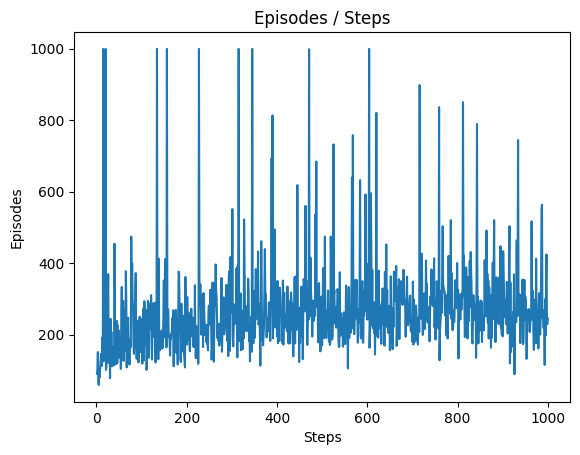

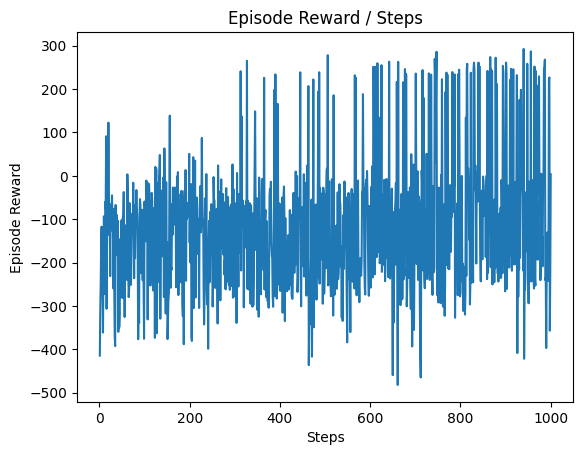

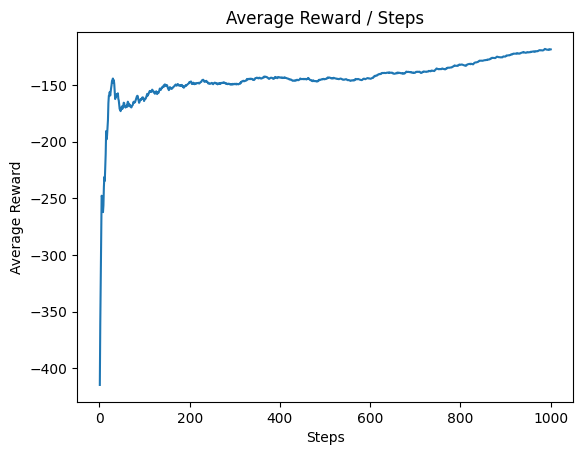

In [55]:
import matplotlib.pyplot as plt

def graph_for_episodes_with_steps():
  x_axis = steps
  y_axis = total_episodes
  plt.plot(x_axis, y_axis)
  plt.xlabel('Steps')
  plt.ylabel('Episodes')
  plt.title('Episodes / Steps')
  plt.show()

def graph_for_episode_rewards_with_steps():
  x_axis = steps
  y_axis = episode_rewards

  plt.plot(x_axis, y_axis)
  plt.xlabel('Steps')
  plt.ylabel('Episode Reward')
  plt.title('Episode Reward / Steps')
  plt.show()


def graph_for_average_reward_with_steps():
    # Calculate average reward
    avg_rewards = [sum(episode_rewards[:i+1]) / len(episode_rewards[:i+1]) for i in range(len(episode_rewards))]

    # Plotting
    plt.plot(steps, avg_rewards)
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title('Average Reward / Steps')
    plt.show()


graph_for_episodes_with_steps()
graph_for_episode_rewards_with_steps()
graph_for_average_reward_with_steps()


In [ ]:
!ls /content/videos